[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/drdave-teaching/OPIM5509Files/blob/main/OPIM5509_Module4_Files/Simple_Predict_The_Stock_Market_DL.ipynb)

# (Simple) Predict the Stock Market!
--------------------------
Now let's pull down some stock data as an example.

In [ ]:
# some useful modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, GRU, LSTM, SpatialDropout1D, Flatten, Bidirectional,  Dropout, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import layers
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
# some stock-specific packages
!pip install yahoo_fin
!pip install requests_html
import yahoo_fin.stock_info as si

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 81 kB 3.9 MB/s 
     |████████████████████████████████| 83 kB 1.8 MB/s 
     |████████████████████████████████| 112 kB 19.9 MB/s 
     |████████████████████████████████| 127 kB 50.7 MB/s 
  Created wheel for fake-useragent: filename=fake_useragent-0.1.11-py3-none-any.whl size=13502 sha256=e46b3a6c9bf2b799602732660539cedeaddad2e244cac7f91b20adb2bb7111ac
  Stored in directory: /root/.cache/pip/wheels/ed/f7/62/50ab6c9a0b5567267ab76a9daa9d06315704209b2c5d032031
  Created wheel for parse: filename=parse-1.19.0-py3-none-any.whl size=24591 sha256=41fa4d602e6950100c6e10637414b87fde85f45eb14807a9d9cc018b2e21a407
  Stored in directory: /root/.cache/pip/wheels/9c/aa/cc/f2228050ccb40f22144b073f15a2c84f11204f29fc0dce028e
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6066 sha256=aa96e1185051988357b9947bb633fff6c3d0ab1acf3849cd9ff4e

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Assign the ticker list that we want to scrap
tickers_list = ['NFLX','IBM','GE','GOOG','AAPL','KO','AMZN','HD','NKE','^DJI','WMT']
# pull historical price data for each stocks to match with our news score later
dow_prices = {ticker : si.get_data(ticker,start_date = '12/27/2017',end_date='01/22/2020',interval='1d') for ticker in tickers_list}

In [ ]:
# take a peak!
dow_prices

{'NFLX':                   open        high         low       close    adjclose  \
 2017-12-27  187.800003  188.100006  185.220001  186.240005  186.240005   
 2017-12-28  187.179993  194.490005  186.850006  192.710007  192.710007   
 2017-12-29  192.509995  193.949997  191.220001  191.960007  191.960007   
 2018-01-02  196.100006  201.649994  195.419998  201.070007  201.070007   
 2018-01-03  202.050003  206.210007  201.500000  205.050003  205.050003   
 ...                ...         ...         ...         ...         ...   
 2020-01-14  344.399994  345.380005  335.519989  338.690002  338.690002   
 2020-01-15  338.679993  343.170013  336.600006  339.070007  339.070007   
 2020-01-16  343.500000  343.559998  335.850006  338.619995  338.619995   
 2020-01-17  341.000000  341.570007  337.380005  339.670013  339.670013   
 2020-01-21  340.000000  341.000000  332.589996  338.109985  338.109985   
 
               volume ticker  
 2017-12-27   4002100   NFLX  
 2017-12-28  10107400   NFLX

In [ ]:
# let's extract just the data we need (adjclose)
# get the adjclose price for the NFLX (one sample)
prep_data = pd.DataFrame(dow_prices['NFLX']['adjclose']).rename(columns = {"adjclose":"NFLX"})

# combine all the tickers (all the rest of the samples)
for i in tickers_list[1:]:
  prep_data[i] = pd.DataFrame(dow_prices[i]['adjclose'])
prep_data

,NFLX,IBM,GE,GOOG,AAPL,KO,AMZN,HD,NKE,^DJI,WMT
2017-12-27,186.240005,116.567627,128.002625,52.468498,40.623154,39.454391,59.112999,170.033386,60.097866,24774.300781,90.927948
2017-12-28,192.710007,117.260376,127.855324,52.407001,40.737453,39.274006,59.305000,169.666809,60.097866,24837.509766,91.056190
2017-12-29,191.960007,116.788376,128.518173,52.320000,40.296928,39.411438,58.473499,169.443314,59.715988,24719.220703,90.460754
2018-01-02,201.070007,117.420197,132.421585,53.250000,41.018414,39.119370,59.450500,168.102280,60.613392,24824.009766,90.314178
2018-01-03,205.050003,120.647812,133.673645,54.124001,41.011284,39.033478,60.209999,168.978394,60.603848,24922.679688,91.101990
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14,338.690002,113.250465,95.135429,71.543999,76.708427,51.345383,93.472000,209.245667,100.419243,28939.669922,111.160309
2020-01-15,339.070007,113.917534,93.870132,71.959999,76.379684,51.987206,93.100998,210.917313,100.292404,29030.220703,110.299202
2020-01-16,338.619995,115.051537,93.632889,72.584999,77.336456,52.097225,93.897003,214.889832,100.858315,29297.640625,110.892418
2020-01-17,339.670013,115.326706,93.395653,74.019501,78.192650,52.207249,93.236000,217.791702,101.990112,29348.099609,109.993027


In [ ]:
prep_data.shape

(519, 11)

Rather than use the raw time series, let's build a model based on past returns (the difference from the previous day).

In [ ]:
# create return features for each ticker,
# we will just use a pct_change as the return
return_data = pd.DataFrame()
for i in tickers_list:
  return_data[i] = prep_data[i].pct_change()
# drop the na records
return_data.dropna(inplace=True)
return_data

,NFLX,IBM,GE,GOOG,AAPL,KO,AMZN,HD,NKE,^DJI,WMT
2017-12-28,0.034740,0.005943,-0.001151,-0.001172,0.002814,-0.004572,0.003248,-0.002156,0.000000,0.002551,0.001410
2017-12-29,-0.003892,-0.004025,0.005184,-0.001660,-0.010814,0.003499,-0.014021,-0.001317,-0.006354,-0.004763,-0.006539
2018-01-02,0.047458,0.005410,0.030372,0.017775,0.017904,-0.007411,0.016708,-0.007914,0.015028,0.004239,-0.001620
2018-01-03,0.019794,0.027488,0.009455,0.016413,-0.000174,-0.002196,0.012775,0.005212,-0.000157,0.003975,0.008723
2018-01-04,0.002829,0.020254,0.020937,0.003621,0.004645,0.014084,0.004476,0.007936,-0.000630,0.006117,0.000905
...,...,...,...,...,...,...,...,...,...,...,...
2020-01-14,-0.000679,-0.005710,-0.007426,-0.005802,-0.013503,-0.002316,-0.011558,-0.002373,0.007439,0.001128,0.002589
2020-01-15,0.001122,0.005890,-0.013300,0.005815,-0.004286,0.012500,-0.003969,0.007989,-0.001263,0.003129,-0.007747
2020-01-16,-0.001327,0.009955,-0.002527,0.008685,0.012527,0.002116,0.008550,0.018834,0.005643,0.009212,0.005378
2020-01-17,0.003101,0.002392,-0.002534,0.019763,0.011071,0.002112,-0.007040,0.013504,0.011222,0.001722,-0.008110


In [ ]:
return_data.shape

(518, 11)

# Pre-processing

In [ ]:
# now, let's make a copy of that data and call it df
df = return_data

# Create Target Variable

In [ ]:
# create binary target
# if Walmart is pos, 1, otherwise, 0
df['Increase'] = np.where(df['WMT']>0,
                          1, # if true
                          0) # if false
df.head(n=10)

,NFLX,IBM,GE,GOOG,AAPL,KO,AMZN,HD,NKE,^DJI,WMT,Increase
2017-12-28,0.034740,0.005943,-0.001151,-0.001172,0.002814,-0.004572,0.003248,-0.002156,0.000000,0.002551,0.001410,1
2017-12-29,-0.003892,-0.004025,0.005184,-0.001660,-0.010814,0.003499,-0.014021,-0.001317,-0.006354,-0.004763,-0.006539,0
2018-01-02,0.047458,0.005410,0.030372,0.017775,0.017904,-0.007411,0.016708,-0.007914,0.015028,0.004239,-0.001620,0
2018-01-03,0.019794,0.027488,0.009455,0.016413,-0.000174,-0.002196,0.012775,0.005212,-0.000157,0.003975,0.008723,1
2018-01-04,0.002829,0.020254,0.020937,0.003621,0.004645,0.014084,0.004476,0.007936,-0.000630,0.006117,0.000905,1
2018-01-05,0.021203,0.004886,0.000539,0.014571,0.011386,-0.000217,0.016163,0.010446,0.008512,0.008803,0.005927,1
2018-01-08,0.009810,0.006031,-0.014024,0.004273,-0.003714,-0.001519,0.014425,-0.002389,0.008909,-0.000509,0.014781,1
2018-01-09,-0.012922,0.002202,0.015317,-0.000614,-0.000115,0.005000,0.004676,0.005520,-0.007126,0.004066,-0.012006,0
2018-01-10,0.015336,0.002136,0.019936,-0.003299,-0.000230,-0.003461,0.001301,-0.006732,0.002029,-0.000657,-0.007172,0
2018-01-11,0.022210,0.000122,0.004754,0.002639,0.005680,-0.000651,0.017818,0.015016,0.001090,0.008104,0.003512,1


In [ ]:
# then shift by one...
# let's see if yesterday's stocks can predict WMT's behavior tmw
# for WMT!
print(df.shape)
df['Increase'] = df['Increase'].shift(-1)
df.head()


(518, 12)


,NFLX,IBM,GE,GOOG,AAPL,KO,AMZN,HD,NKE,^DJI,WMT,Increase
2017-12-28,0.034740,0.005943,-0.001151,-0.001172,0.002814,-0.004572,0.003248,-0.002156,0.000000,0.002551,0.001410,0.0
2017-12-29,-0.003892,-0.004025,0.005184,-0.001660,-0.010814,0.003499,-0.014021,-0.001317,-0.006354,-0.004763,-0.006539,0.0
2018-01-02,0.047458,0.005410,0.030372,0.017775,0.017904,-0.007411,0.016708,-0.007914,0.015028,0.004239,-0.001620,1.0
2018-01-03,0.019794,0.027488,0.009455,0.016413,-0.000174,-0.002196,0.012775,0.005212,-0.000157,0.003975,0.008723,1.0
2018-01-04,0.002829,0.020254,0.020937,0.003621,0.004645,0.014084,0.004476,0.007936,-0.000630,0.006117,0.000905,1.0


In [ ]:
# and there should be one NaN at the botton
df.tail() # and there is!

,NFLX,IBM,GE,GOOG,AAPL,KO,AMZN,HD,NKE,^DJI,WMT,Increase
2020-01-14,-0.000679,-0.005710,-0.007426,-0.005802,-0.013503,-0.002316,-0.011558,-0.002373,0.007439,0.001128,0.002589,0.0
2020-01-15,0.001122,0.005890,-0.013300,0.005815,-0.004286,0.012500,-0.003969,0.007989,-0.001263,0.003129,-0.007747,1.0
2020-01-16,-0.001327,0.009955,-0.002527,0.008685,0.012527,0.002116,0.008550,0.018834,0.005643,0.009212,0.005378,0.0
2020-01-17,0.003101,0.002392,-0.002534,0.019763,0.011071,0.002112,-0.007040,0.013504,0.011222,0.001722,-0.008110,1.0
2020-01-21,-0.004593,0.006218,-0.012701,0.002709,-0.006777,0.004039,0.014630,0.004484,0.000479,-0.005181,0.005480,NaN


In [ ]:
# we will just delete the last row because of the NaN
df.drop(df.tail(1).index,inplace=True) # drop last 1 rows
print(df.shape)

(517, 12)


In [ ]:
# we have to make sure we have balanced data
df['Increase'].value_counts()

1.0    275
0.0    242
Name: Increase, dtype: int64

# Visualize the Time Series

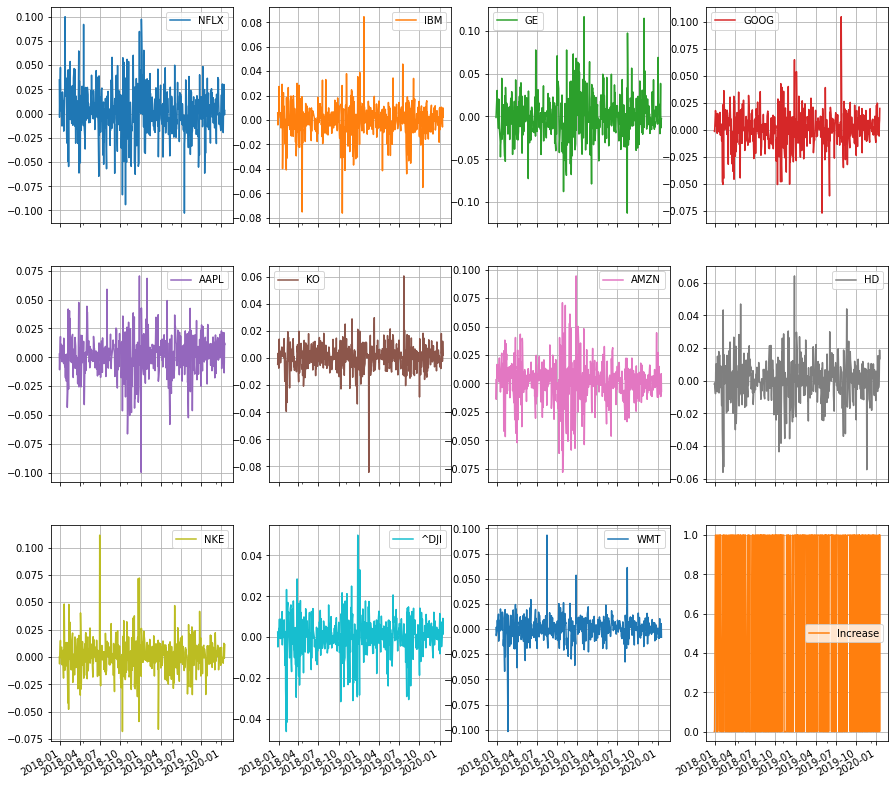

In [ ]:
df.plot(subplots=True,
        grid=True,
        layout=(3,4),
         figsize=(15,15))
plt.show()

In [ ]:
# # plot cumulative increase for ease
# tmp = df['Increase']
# tmp.replace(to_replace=0,value=-1, inplace=True)
# tmp = tmp.cumsum() # cumulative sum
# tmp.plot()
# plt.show()

# Data Partitioning

In [ ]:
# Split data into X and Y
y = df['Increase']
X = df.drop('Increase', axis=1)
print(df.shape, X.shape, y.shape)

(517, 12) (517, 11) (517,)


In [ ]:
# split the data into train and test partitions
# we will use 50% of the data for train, and rest for validation
train_pct_index = int(0.5 * len(X))
X_train, X_test = X[:train_pct_index], X[train_pct_index:]
y_train, y_test = y[:train_pct_index], y[train_pct_index:]

In [ ]:
# X is still a 2D array
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(258, 11) (258,)
(259, 11) (259,)


In [ ]:
# check for any missing vals
X_test.tail()

,NFLX,IBM,GE,GOOG,AAPL,KO,AMZN,HD,NKE,^DJI,WMT
2020-01-13,0.029996,-0.000658,0.038560,0.006645,0.021364,0.010805,0.004323,-0.003925,0.012488,0.002889,-0.004296
2020-01-14,-0.000679,-0.005710,-0.007426,-0.005802,-0.013503,-0.002316,-0.011558,-0.002373,0.007439,0.001128,0.002589
2020-01-15,0.001122,0.005890,-0.013300,0.005815,-0.004286,0.012500,-0.003969,0.007989,-0.001263,0.003129,-0.007747
2020-01-16,-0.001327,0.009955,-0.002527,0.008685,0.012527,0.002116,0.008550,0.018834,0.005643,0.009212,0.005378
2020-01-17,0.003101,0.002392,-0.002534,0.019763,0.011071,0.002112,-0.007040,0.013504,0.011222,0.001722,-0.008110


# Normalize the Data


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler() # this like 2D data
X_train = scaler.fit_transform(X_train) # fit and transform
X_test = scaler.transform(X_test) # transform simply means APPLY the learned coordinate
print(X_train.shape, X_test.shape)

(258, 11) (259, 11)


# Transform the shape
In order to use our function, we will join back X_train and y_train; and then X_test and y_test. Then we will need to run split_sequences TWICE (once for train, once for test).

In [ ]:
# save everything as a dataframe
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# reset the index on everything
# issue with dates and integers
X_train.reset_index(inplace=True, drop=True)
X_test.reset_index(inplace=True, drop=True)
y_train.reset_index(inplace=True, drop=True)
y_test.reset_index(inplace=True, drop=True)

# put X_train and y_train together (we did not scale Y)
# put X_test and y_test together (again, we did not scale Y before)
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)
print(df.shape, df_train.shape, df_test.shape)

(517, 12) (258, 12) (259, 12)


In [ ]:
# check the head
df_train.head()

,0,1,2,3,4,5,6,7,8,9,10,Increase
0,1.084008,0.423680,0.045840,-0.080050,0.159704,-0.514970,0.073522,-0.145842,-0.053260,0.230724,0.091834,0.0
1,-0.216670,-0.216317,0.295895,-0.107362,-0.553550,0.337212,-0.682811,-0.087203,-0.399347,-0.407731,-0.441224,0.0
2,1.512193,0.389463,1.290098,0.980277,0.949538,-0.814689,0.663056,-0.548481,0.765235,0.378056,-0.111389,1.0
3,0.580798,1.806951,0.464466,0.904053,0.003341,-0.264069,0.490794,0.369318,-0.061837,0.354976,0.582180,1.0
4,0.009596,1.342504,0.917660,0.188196,0.255542,1.454811,0.127304,0.559807,-0.087585,0.541974,0.057937,1.0


In [ ]:
# check the head
df_test.head()

,0,1,2,3,4,5,6,7,8,9,10,Increase
0,-0.118226,0.502889,-0.185408,-0.098689,0.901250,-2.055827,0.006350,0.728122,-0.152628,0.344407,-0.221100,1.0
1,0.408931,0.627314,2.134467,-0.239943,0.179724,1.101343,-0.153195,-0.255754,-0.174163,0.456919,0.046731,0.0
2,1.255250,-0.131864,0.091262,-0.701478,-0.501420,0.573373,-0.482852,0.141580,-0.324102,-0.013710,-0.087484,1.0
3,-0.549390,-0.523483,-0.085332,-0.676141,-0.774595,-0.456015,-0.692106,-0.228945,-0.017438,-0.305247,0.075040,1.0
4,2.108769,0.756742,-0.662691,1.724354,1.083644,0.908255,1.484432,-0.910115,1.228020,0.576637,0.915339,1.0


In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(0,len(sequences)): # UPDATED FOR N_STEPS
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
# almost ready to play
n_steps = 5
X_train, y_train = split_sequences(np.array(df_train), n_steps)
X_test, y_test = split_sequences(np.array(df_test), n_steps)
# check your work
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape) # looks good!

(254, 5, 11) (254,)
(255, 5, 11) (255,)


Play with different time steps! 3, 5, 10, 20... any luck?

In [ ]:
# verify no NaN values
print(np.isnan(X_train).sum())
print(np.isnan(y_train).sum())
print(np.isnan(X_test).sum())
print(np.isnan(y_test).sum())

0
0
0
0


In [ ]:
# verify distribution of target variable
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0., 1.]), array([128, 126]))
(array([0., 1.]), array([111, 144]))


# LSTM - Stock Market Binary Classification

In [ ]:
# define what you need
n_steps = X_train.shape[1]
n_features = X_train.shape[2]

# define model
model = Sequential()
model.add((LSTM(64, return_sequences=True, activation='relu',
                input_shape=(n_steps, n_features))))
model.add(Dropout(0.1))
model.add((LSTM(32,activation='relu')))
model.add(Dropout(0.1))
model.add(Dense(32,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))
model.summary()

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# early stopping
es = EarlyStopping(monitor='val_accuracy',
                   mode='max',
                   patience=20,
                   verbose=1,
                   restore_best_weights=True)

# fit model, if you run locally and remember the seed, you will be able to rerun 6 epochs and get the best val accuracy
model.fit(X_train, y_train,
          epochs=100,
          batch_size=5,
          validation_data=(X_test, y_test),
          verbose=1,
          callbacks=[es],
          shuffle=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 64)             19456     
                                                                 
 dropout (Dropout)           (None, 5, 64)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

In [ ]:
# you may get different results every time!
# depends on your use of validation data

You can also try to predict how much the Dow will go up or down the next day (percentage - play around with this example! And don't forget to change your metrics in compile or activation function in the last layer.

[[31 80]
 [47 97]]
              precision    recall  f1-score   support

         0.0       0.40      0.28      0.33       111
         1.0       0.55      0.67      0.60       144

    accuracy                           0.50       255
   macro avg       0.47      0.48      0.47       255
weighted avg       0.48      0.50      0.48       255



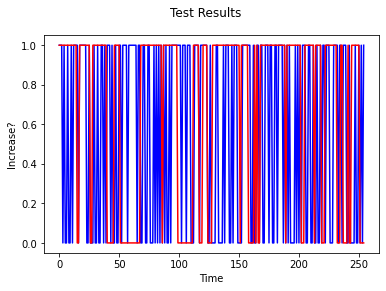

In [ ]:
# put it all together for other models

# make a prediction
pred = model.predict(X_test)# the pred
# print(pred) # round them!

pred = np.round(pred,0)
# print(pred) # run all if you get an error...

# confusion matrix - put this at the top!
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print(confusion_matrix(y_test, pred)) # looks pretty good!
print(classification_report(y_test, pred))

# show timeseries plot on the train and validation data
plt.plot(np.arange(X_test.shape[0]), y_test, color='blue') # actual data
plt.plot(np.arange(X_test.shape[0]), pred, color='red') # predicted data
plt.suptitle('Test Results')
plt.xlabel('Time')
plt.ylabel('Increase?')
plt.show()